In [89]:
import numpy as np 
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt


In [90]:
filepath = "/home/rp/abhay_ws/contact-manifold-state-estimation/real_data/bnc_raw_kuka_data.csv"
df = pd.read_csv(filepath)
# rename columns
df = df.rename(columns={
    'axisQMsr_LBR_iiwa_14_R820_1[0]': 'J0',
    'axisQMsr_LBR_iiwa_14_R820_1[1]': 'J1',
    'axisQMsr_LBR_iiwa_14_R820_1[2]': 'J2',
    'axisQMsr_LBR_iiwa_14_R820_1[3]': 'J3',
    'axisQMsr_LBR_iiwa_14_R820_1[4]': 'J4',
    'axisQMsr_LBR_iiwa_14_R820_1[5]': 'J5',
    'axisQMsr_LBR_iiwa_14_R820_1[6]': 'J6',    
})
df.keys()

Index(['ZeitInSec', 'ZeitInNanoSec', 'cartForce1_X', 'cartForceVar1_X',
       'cartForce1_Y', 'cartForceVar1_Y', 'cartForce1_Z', 'cartForceVar1_Z',
       'cartTorque1_TauX', 'cartVarTorque1_TauX', 'cartTorque1_TauY',
       'cartVarTorque1_TauY', 'cartTorque1_TauZ', 'cartVarTorque1_TauZ', 'J0',
       'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'CartPosMsr1_X', 'CartPosMsr1_Y',
       'CartPosMsr1_Z', 'CartPosCmd1_X', 'CartPosCmd1_Y', 'CartPosCmd1_Z'],
      dtype='object')

In [91]:
df.keys()

Index(['ZeitInSec', 'ZeitInNanoSec', 'cartForce1_X', 'cartForceVar1_X',
       'cartForce1_Y', 'cartForceVar1_Y', 'cartForce1_Z', 'cartForceVar1_Z',
       'cartTorque1_TauX', 'cartVarTorque1_TauX', 'cartTorque1_TauY',
       'cartVarTorque1_TauY', 'cartTorque1_TauZ', 'cartVarTorque1_TauZ', 'J0',
       'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'CartPosMsr1_X', 'CartPosMsr1_Y',
       'CartPosMsr1_Z', 'CartPosCmd1_X', 'CartPosCmd1_Y', 'CartPosCmd1_Z'],
      dtype='object')

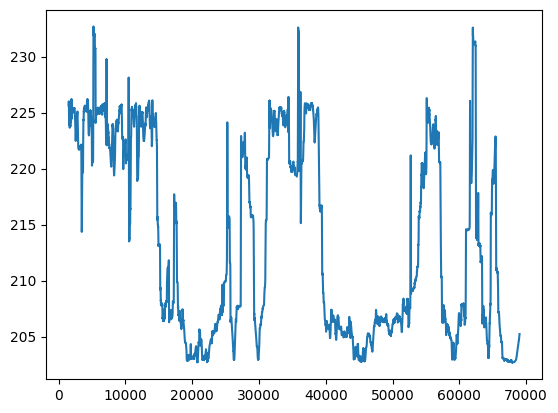

In [105]:
plt.plot(df['FK_Z'][1500:69000])

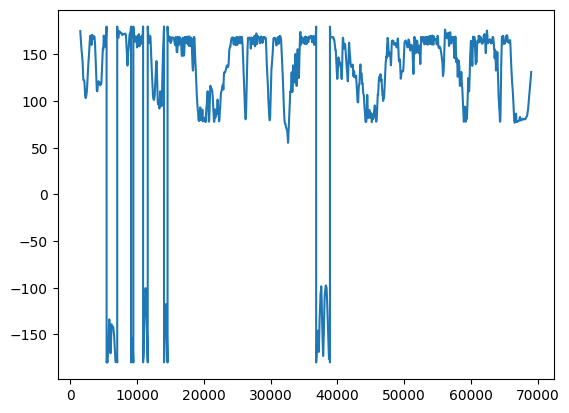

In [115]:
plt.plot(df['FK_A'].iloc[1500:69000])
# plt.plot(pd.concat([df['FK_A'].iloc[1500:35000], df['FK_A'].iloc[40000:69000]]).values)

In [106]:
# filter 
# df_filtered = df[5000:65000]
df_filtered = df[1500:69000]

In [107]:
# forward kinematics 

def z_rotation_matrix(theta): 
    """ Rotation around z-axis """
    return np.array([
        [np.cos(theta), -np.sin(theta), 0, 0],
        [np.sin(theta),  np.cos(theta), 0, 0],
        [0,             0,             1, 0],
        [0,             0,             0, 1]
    ])

def kuka_fk(
        joint_positions, 
        link_lengths = np.array([0.1575, 0.2025, 0.2045, 0.2155, 0.1845, 0.2155, 0.0810, 0.0450]) * 1e3 
    ): 
    if joint_positions.shape[0] == 7:
        joint_positions = np.concatenate((joint_positions, np.array([0])), axis=0) 

    tf_Ji_o = np.empty((8,4,4)) 
    tf_Ji_o[0,:,:] = np.array([
        [ 1.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  1.    ,  0.    ,  0.    ],
        [-0.    ,  0.    ,  1.    ,  link_lengths[0]],
        [ 0.    ,  0.    ,  0.    ,  1.    ]])
    tf_Ji_o[1,:,:] = np.array([
        [-1, 0,  0, 0],
        [ 0, 0,  1, 0],
        [ 0, 1,  0, link_lengths[1]],
        [ 0, 0, 0, 1]])
    tf_Ji_o[2,:,:] = np.array([
        [-1, 0, 0, 0],
        [ 0, 0, 1, link_lengths[2]],
        [ 0, 1, 0, 0],
        [ 0, 0, 0, 1]])
    tf_Ji_o[3,:,:] = np.array([
        [ 1, 0, 0, 0],
        [ 0, 0,-1, 0],
        [ 0, 1, 0, link_lengths[3]],
        [ 0, 0, 0, 1]])
    tf_Ji_o[4,:,:] = np.array([
        [-1, 0, 0, 0],
        [ 0, 0, 1, link_lengths[4]],
        [ 0, 1, 0, 0],
        [ 0, 0, 0, 1]])
    tf_Ji_o[5,:,:] = np.array([
        [ 1, 0,  0,  0],
        [ 0, 0, -1,  0],
        [ 0, 1,  0,  link_lengths[5]],
        [ 0, 0,  0, 1]])
    tf_Ji_o[6,:,:] = np.array([
        [-1, 0, 0, 0],
        [ 0, 0, 1, link_lengths[6]],
        [ 0, 1, 0, 0],
        [ 0, 0, 0, 1]])
    tf_Ji_o[7,:,:] = np.array([
        [ 1,  0,  0,  0.   ],
        [ 0,  1,  0,  0.   ],
        [ 0,  0,  1,  link_lengths[7]],
        [ 0,  0,  0,  1.   ]])
    
    tf = np.eye(4)
    for i in range(8): 
        tf = tf @ tf_Ji_o[i,:,:] @ z_rotation_matrix(joint_positions[i])  
    return tf 

def kuka_fk_batch(
        joint_positions, 
        link_lengths = np.array([0.1575, 0.2025, 0.2045, 0.2155, 0.1845, 0.2155, 0.0810, 0.0450])*1e3
    ): 
    n = joint_positions.shape[0] 
    tf = [] 
    for i in range(n): 
        tf.append(kuka_fk(joint_positions[i,:], link_lengths)) 
    tf = np.array(tf) 
    # tf[:,:3,3] *= 1000 
    tf = tf.reshape((n,4,4))
    return tf 

# compute end-effector poses
joint_positions = df_filtered[['J0', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6']].values.astype(np.float32) * np.pi / 180.0
tf_ee = kuka_fk_batch(joint_positions)
ee_positions = tf_ee[:,:3,3]
ee_rotations = R.from_matrix(tf_ee[:,:3,:3]).as_euler('xyz', degrees=True)
# ee_rotations = R.from_matrix(tf_ee[:,:3,:3]).as_quat()  # x,y,z,w
# concatenate positions and rotations
c,b,a = ee_rotations[:,0], ee_rotations[:,1], ee_rotations[:,2]
ee_rotations_abc = np.stack((a,b,c), axis=1)  
ee_poses = np.concatenate((ee_positions, ee_rotations_abc), axis=1)
ee_poses.shape

df_filtered['FK_X'] = ee_poses[:,0] 
df_filtered['FK_Y'] = ee_poses[:,1] 
df_filtered['FK_Z'] = ee_poses[:,2] 
df_filtered['FK_A'] = ee_poses[:,3] 
df_filtered['FK_B'] = ee_poses[:,4] 
df_filtered['FK_C'] = ee_poses[:,5] 

df_filtered.describe()

/tmp/ipykernel_746736/1305665171.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['FK_X'] = ee_poses[:,0]
/tmp/ipykernel_746736/1305665171.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['FK_Y'] = ee_poses[:,1]
/tmp/ipykernel_746736/1305665171.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

,ZeitInSec,ZeitInNanoSec,cartForce1_X,cartForceVar1_X,cartForce1_Y,cartForceVar1_Y,cartForce1_Z,cartForceVar1_Z,cartTorque1_TauX,cartVarTorque1_TauX,...,CartPosMsr1_Z,CartPosCmd1_X,CartPosCmd1_Y,CartPosCmd1_Z,FK_X,FK_Y,FK_Z,FK_A,FK_B,FK_C
count,6.750000e+04,6.750000e+04,67500.000000,67500.000000,67500.000000,67500.000000,67500.000000,67500.000000,67500.000000,67500.000000,...,67500.000000,67500.000000,6.750000e+04,67500.000000,67500.000000,67500.000000,67500.000000,67500.000000,67500.000000,67500.000000
mean,1.357000e+09,5.012111e+08,0.315234,-1.521557,0.436937,3.792443,-11.008102,-1.640880,0.020116,-0.267499,...,213.448070,715.005529,-4.383315e+01,323.786094,718.340180,-37.139023,213.448028,118.036707,0.071116,45.471343
std,9.742892e+01,2.886107e+08,2.225406,4.147249,1.470264,1.873050,1.408315,0.484464,0.518450,0.911180,...,8.693609,0.000000,7.105480e-15,0.000000,8.666232,9.657392,8.693609,82.554155,4.407027,171.429663
min,1.357000e+09,4.000000e+06,-14.874115,-9.416430,-12.498928,-1.875247,-23.154354,-3.371654,-4.329259,-2.142034,...,202.687880,715.005529,-4.383315e+01,323.786094,676.542149,-72.033045,202.687760,-179.982366,-17.742378,-179.999892
25%,1.357000e+09,2.490000e+08,-0.360207,-4.584115,-0.284480,2.903304,-11.901650,-1.926918,-0.180105,-0.875873,...,205.775459,715.005529,-4.383315e+01,323.786094,715.572150,-41.823861,205.775429,105.751374,-2.437713,-177.128838
50%,1.357000e+09,4.990000e+08,0.343764,-3.624580,0.419837,3.798941,-11.226314,-1.572570,0.023571,-0.689358,...,209.780025,715.005529,-4.383315e+01,323.786094,717.989781,-38.148033,209.780005,149.241217,0.160682,175.993212
75%,1.357000e+09,7.490000e+08,0.998277,2.245698,1.108816,5.217534,-10.072706,-1.376291,0.247218,0.474814,...,222.680206,715.005529,-4.383315e+01,323.786094,721.678561,-31.514605,222.680174,165.087938,2.437388,178.477748
max,1.357000e+09,9.990000e+08,17.954350,6.420578,11.627296,9.226383,8.673106,0.557419,4.935215,2.093132,...,232.683342,715.005529,-4.383315e+01,323.786094,755.862047,-2.404958,232.683318,179.997680,18.161801,179.999978


In [108]:
# save to csv 
df_filtered.to_csv("/home/rp/abhay_ws/contact-manifold-state-estimation/real_data/bnc_processed_kuka_data.csv", index=False)

In [ ]:
df.loc[20000,['FK_X','FK_Y','FK_Z','FK_A','FK_B','FK_C']]

FK_X    716.765114
FK_Y    -38.543611
FK_Z    203.204122
FK_A     80.968380
FK_B     -1.840922
FK_C    178.643423
Name: 20000, dtype: float64

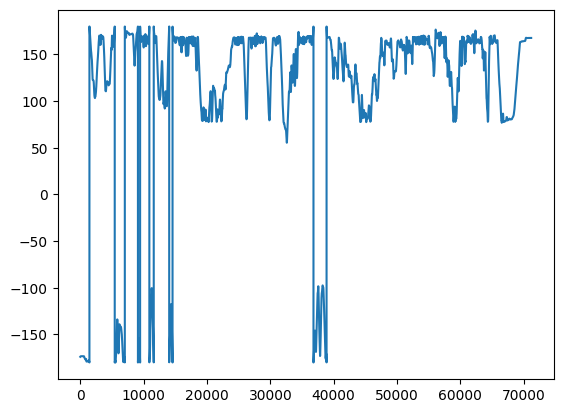

In [85]:
import matplotlib.pyplot as plt

plt.plot(df['FK_A'])